# Supervised learning for a layer of multiple neurons
## Delta rule for multi-class classification

The `DeltaRule.ipynb` notebook trained a single neuron to be a "two"-detector.\
Here we will train 10 neurons to recognize all 10 digit classes in the MNIST dataset

For the weights and biases of the neurons, we will use the `torch.nn.Linear` class,\
an abstraction of a linear layer of neurons.

## Preliminaries

In [1]:
!pip install matplotlib --upgrade      # to make subfigures work on Colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 34.7 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [2]:
import torch
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import tensorflow as tf

# display plots inline (in the notebook rather than another window)
%matplotlib inline

#plt.rcParams['image.cmap'] = 'gray'

plt.rcParams['image.cmap'] = 'hot'

torch.manual_seed(485)        # manually seed the random number generator (useful if you want reproducible experiments)

#### Read in the training data

In [3]:
mnist = datasets.MNIST(root='data', train=True, download=True) # train data only
trainimages = mnist.data
trainlabels = mnist.targets

100%|██████████| 9912422/9912422 [00:00<00:00, 118451007.12it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 21196096.91it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 29066671.98it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12863287.49it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



#### other parameters and arrays for keeping track of performance

In [4]:
tmax, nrow, ncol = trainimages.size()
nclass = len(torch.unique(trainlabels))    # number of classes

errcl = torch.zeros(tmax)    # classification error vs. time
entropy = torch.zeros(tmax)   # cross entropy loss vs. time

tshow = 1000   # how often to pause and plot
eta = 0.01  # learning rate parameter (controls length of gradient step)

#### visualizing network output and learning curves
[`subfigures`](https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subfigures.html) are used to make two figures side by side, each containing subplots

In [5]:
def viz(fig, logit, probs, errcl, entropy, weight, bias):
    subfigs = fig.subfigures(1, 2, wspace=0.07)

    axleft = subfigs[0].subplots(2, 2)  # left-hand subfigure will show the 10 outputs and error/loss vs. time

    axleft[0, 0].bar(range(nclass), bias)
    axleft[0, 0].bar(range(nclass), logit-bias, bottom=bias)  # the two colors show contributions from w\cdot x and bias.
    axleft[0, 0].set_xticks(range(len(logit)))
    axleft[0, 0].set_title("logits")

    axleft[0, 1].bar(range(nclass), probs)
    axleft[0, 1].set_ylim(0, 1)
    axleft[0, 1].set_xticks(range(len(logit)))
    axleft[0, 1].set_title("predicted probabilities")

    axleft[1, 0].plot(torch.cumsum(errcl, dim=0)/(1+torch.arange(len(errcl))))
    axleft[1, 0].set_title("classification error")

    axleft[1, 1].plot(torch.cumsum(entropy, dim=0)/(1+torch.arange(len(entropy))))
    axleft[1, 1].set_title("cross entropy loss")

    axright = subfigs[1].subplots(3, 4)    # right-hand subfigure will show the weight vectors
    axright[2, 2].axis('off')
    axright[2, 3].axis('off')
    for i in range(nclass):
        axright[i//4, i%4].imshow(weight[i].view(nrow,ncol))
        axright[i//4, i%4].axis('off')

    display.clear_output(wait=True)
    display.display(fig)
    fig.clf()

## Multi-class with multiple binary classifications

#### Define a linear layer going from `nrow*ncol` pixels to `nclass` neurons.
The layer is completely linear; no activation function is included.

In [6]:
model = nn.Linear(nrow*ncol, nclass)
model.requires_grad_(False)  # set to `False`, because we are not using autograd.

Linear(in_features=784, out_features=10, bias=True)

`model.weight` contains the weight vectors of the 10 neurons.\
The dimensions of the matrix are 10x784.\
(Warning: this is the opposite order of arguments in `nn.Linear`.)

In [7]:
model.weight.shape

torch.Size([10, 784])

`model.bias` contains the biases of the ten neurons.

In [8]:
model.bias.shape

torch.Size([10])

#### Main loop of delta rule training
The linear layer is followed by the `torch.sigmoid` function,\
so that each neuron independently estimates the probability that the image belongs to the corresponding digit class.\
You can experiment with `tshow=1` to see the early behavior of training.\
You can also try different values of the learning rate parameter `eta`.

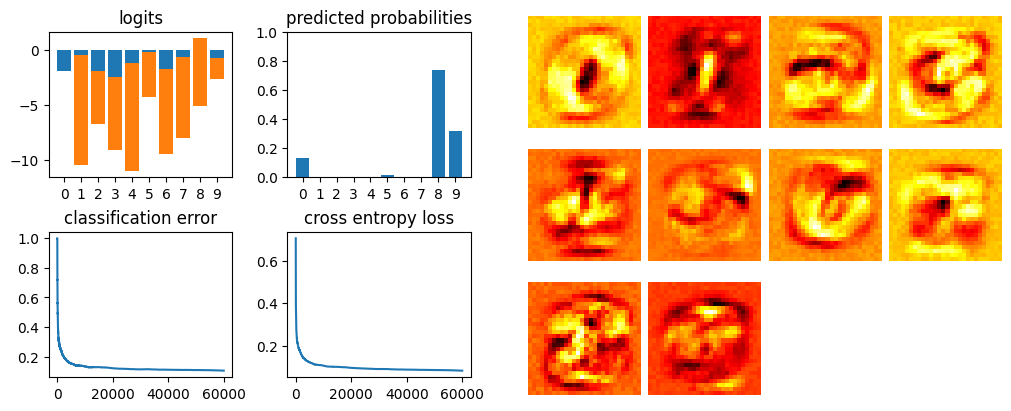

<Figure size 1000x400 with 0 Axes>

In [9]:
fig = plt.figure(constrained_layout=True, figsize=(10, 4))

for t in range(tmax):     # iterate through the training examples
    x = trainimages[t]/255            # normalize max value to one
    x = x.view(-1)                    # flatten 2D image into vector
    logit = model(x)
    actual = torch.sigmoid(logit)
    desired = F.one_hot(trainlabels[t], 10).float()
    delta = desired - actual
    model.weight += eta*torch.outer(delta, x)
    model.bias += eta*delta

    errcl[t] = torch.max(logit, 0).indices.item() != trainlabels[t]
    entropy[t] = F.binary_cross_entropy_with_logits(logit, desired)    # cross entropy loss

    if (t+1) % tshow == 0:    # display every nwindow time steps
        viz(fig, logit, actual, errcl[:t], entropy[:t], model.weight, model.bias)

## Exercise

### Multi-class with softmax
Modify the above code to implement the delta rule when the softmax nonlinearity is used for the output of the 10 neurons.

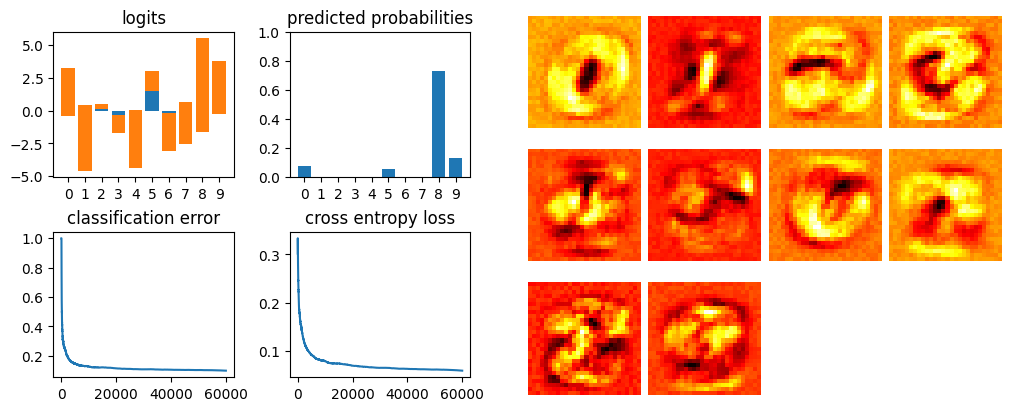

<Figure size 1000x400 with 0 Axes>

In [13]:
fig = plt.figure(constrained_layout=True, figsize=(10, 4))
modelM = nn.Linear(nrow*ncol, nclass)
modelM.requires_grad_(False)
errclM = torch.zeros(tmax)    # classification error vs. time
entropyM = torch.zeros(tmax)


for t in range(tmax):     # iterate through the training examples
    x = trainimages[t]/255            # normalize max value to one
    x = x.view(-1)    # flatten 2D image into vector
    logit = modelM(x)
    actual = F.softmax(logit, dim=0)
    desired = F.one_hot(trainlabels[t], 10).float()

    delta = desired - actual

    modelM.weight += eta*torch.outer(delta, x)
    modelM.bias += eta*delta

    errclM[t] = torch.max(logit, 0).indices.item() != trainlabels[t]
    entropyM[t] = F.binary_cross_entropy(actual, desired)    # cross entropy loss

    if (t+1) % tshow == 0:    # display every nwindow time steps
        viz(fig, logit, actual, errclM[:t], entropyM[:t], modelM.weight, modelM.bias)